In [15]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
ANFIS OPT v3 – completo con gráficos
-----------------------
Optimización tras la primera ejecución fallida:
• Focal Loss con vector α balanceado.
• Penalización L1 suave y poda sólo al final.
• Monitorización AUC/F1 por época.
• Umbral F1 y evaluación final con latencia.
"""

import os, random, warnings, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve)
from graphviz import Digraph
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import joblib


# ----------------------------------------------------------
# CONFIG
# ----------------------------------------------------------
TOP_K_MF   = 2
N_GAUSS    = 3
N_GBELL    = 2
ALPHA_VEC  = torch.tensor([0.25, 0.75])
GAMMA      = 1.5
L1_LAMBDA  = 5e-5
PRUNE_FINAL= True
EPOCHS     = 60
LR_MAX     = 3e-3
SEED       = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Directorio de salida para figuras y tablas
os.makedirs('outputs', exist_ok=True)
# Crear carpeta de modelos si no existe
os.makedirs('models', exist_ok=True)

def generate_table_1(y, y_tr, y_val, y_te, output_path='outputs/table1_dataset_splits.csv'):
    total = len(y)
    table1 = pd.DataFrame({
        "Class": ["normal", "ddos"],
        "# Instances": [np.sum(y == 0), np.sum(y == 1)],
        "Train %": [f"{np.sum(y_tr == 0)/total:.1%}", f"{np.sum(y_tr == 1)/total:.1%}"],
        "Val %": [f"{np.sum(y_val == 0)/total:.1%}", f"{np.sum(y_val == 1)/total:.1%}"],
        "Test %": [f"{np.sum(y_te == 0)/total:.1%}", f"{np.sum(y_te == 1)/total:.1%}"],
        "Balance (SMOTE v1)": ["✓", "✓"],
        "Balance (v2, v3)": ["✗", "✗"]
    })
    table1.to_csv(output_path, index=False)
    print(f"Table 1 saved to {output_path}")
    return table1

# Table 2 – Hyper-parameters
def generate_table_2(ALPHA_VEC, GAMMA, LR_MAX, L1_LAMBDA, TOP_K_MF, N_GAUSS, N_GBELL, output_path='outputs/table2_hyperparams.csv'):
    table2 = pd.DataFrame({
        "Parameter": [
            "Focal Loss α", "Focal Loss γ", "OneCycle LR_max", "OneCycle pct_start",
            "L1 λ", "# MF per variable", "Pruning Threshold", "Pruning Epochs"
        ],
        "Value": [
            list(ALPHA_VEC.cpu().numpy()), GAMMA, LR_MAX, 0.3,
            L1_LAMBDA, TOP_K_MF * (N_GAUSS + N_GBELL), 1e-3, "[15, 25]"
        ]
    })
    table2.to_csv(output_path, index=False)
    print(f"Table 2 saved to {output_path}")
    return table2


# ----------------------------------------------------------
# Datos
# ----------------------------------------------------------
print('-> Cargando datasets …')
X = pd.read_csv('13_X_fuzzy_filtrado_final.csv')
y = pd.read_csv('06_y_labels.csv').iloc[:, 0].values.ravel()
scaler = MinMaxScaler(); X_scaled = scaler.fit_transform(X)
# Guardar el MinMaxScaler
scaler_path = 'models/minmax_scaler_v3.joblib'
joblib.dump(scaler, scaler_path)
print(f"MinMaxScaler guardado en: {scaler_path}")

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=SEED)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED)

X_tr_t = torch.tensor(X_tr, dtype=torch.float32, device=DEVICE)
X_val_t= torch.tensor(X_val, dtype=torch.float32, device=DEVICE)
X_te_t = torch.tensor(X_te, dtype=torch.float32, device=DEVICE)
y_tr_t = torch.tensor(y_tr, dtype=torch.long,  device=DEVICE)
y_val_t= torch.tensor(y_val, dtype=torch.long, device=DEVICE)
y_te_t = torch.tensor(y_te, dtype=torch.long,  device=DEVICE)

# Generar tablas para el artículo
table1 = generate_table_1(y, y_tr, y_val, y_te)
table2 = generate_table_2(ALPHA_VEC, GAMMA, LR_MAX, L1_LAMBDA, TOP_K_MF, N_GAUSS, N_GBELL)
print(table1)
print(table2)


# ----------------------------------------------------------
# MF helpers
# ----------------------------------------------------------
class GaussianMF(nn.Module):
    def __init__(self, mu, sigma):
        super().__init__(); self.mu=nn.Parameter(torch.tensor(mu)); self.sigma=nn.Parameter(torch.tensor(sigma))
    def forward(self, x):
        return torch.exp(-0.5*((x-self.mu)/torch.clamp(self.sigma,min=1e-3))**2)

class GBellMF(nn.Module):
    def __init__(self, a,b,c):
        super().__init__(); self.a=nn.Parameter(torch.tensor(a)); self.b=nn.Parameter(torch.tensor(b)); self.c=nn.Parameter(torch.tensor(c))
    def forward(self,x):
        a=torch.clamp(self.a,min=1e-3); b=torch.clamp(self.b,min=1e-3)
        return 1.0/(1+torch.abs((x-self.c)/a)**(2*b))

def init_centers(Xnp,k):
    return np.array([np.sort(KMeans(k, n_init=10, random_state=SEED).fit(col.reshape(-1,1)).cluster_centers_.flatten()) for col in Xnp.T])

# ----------------------------------------------------------
# Modelo ANFIS
# ----------------------------------------------------------
class ANFISHybrid(nn.Module):
    def __init__(self,n_in):
        super().__init__(); self.n_in=n_in
        g_c=init_centers(X_scaled,N_GAUSS); gb_c=init_centers(X_scaled,N_GBELL)
        self.mfs=nn.ModuleList([nn.ModuleList([* [GaussianMF(c,0.1) for c in g_c[i]], * [GBellMF(0.1,2.0,c) for c in gb_c[i]]]) for i in range(n_in)])
        self.rules=[]; self.n_rules=0; self.rule_cls_w=nn.Parameter(torch.empty(0,2))
    def forward(self,x):
        if self.n_rules==0: raise RuntimeError('Sin reglas')
        if not hasattr(self,'rule_idx_tensor'):
            self.rule_idx_tensor=torch.tensor(self.rules,dtype=torch.long,device=x.device)
        mf_all=torch.stack([torch.stack([mf(x[:,i].unsqueeze(1)).view(-1) for mf in mfs],dim=-1) for i,mfs in enumerate(self.mfs)],dim=1)
        B,R,I=x.size(0),self.n_rules,self.n_in; sel=torch.empty(B,R,I,device=x.device)
        for i in range(I):
            idx=self.rule_idx_tensor[:,i].unsqueeze(0).expand(B,R).unsqueeze(-1)
            sel[:,:,i]=torch.gather(mf_all[:,i].unsqueeze(1).expand(B,R,-1),2,idx).squeeze(-1)
        strengths=sel.prod(dim=2); logits=(strengths/ (strengths.sum(dim=1,keepdim=True)+1e-8)) @ self.rule_cls_w
        return logits,strengths

@torch.no_grad()
def data_driven_rules(model,X_t,top_k=1):
    s=set()
    for xb in X_t.split(1024):
        mf_vals=torch.stack([torch.stack([mf(xb[:,i].unsqueeze(1)).squeeze(1) for mf in mfs],dim=1) for i,mfs in enumerate(model.mfs)],dim=1)
        for b in range(mf_vals.size(0)):
            s.add(tuple(mf_vals.topk(top_k,dim=-1).indices[b,:,0].tolist()))
    return list(s)

class FocalLoss(nn.Module):
    def __init__(self,a_vec,gamma): super().__init__(); self.register_buffer('a',a_vec); self.g=gamma
    def forward(self,logits,tgt): ce=F.cross_entropy(logits,tgt,reduction='none'); pt=torch.exp(-ce); return (self.a[tgt]*(1-pt)**self.g*ce).mean()

@torch.no_grad()
def prune(model,thr=1e-3):
    k=(model.rule_cls_w.abs().sum(1)>thr); model.rule_cls_w=nn.Parameter(model.rule_cls_w[k]); model.rules=[r for keep,r in zip(k.tolist(),model.rules) if keep]; model.n_rules=len(model.rules); 
    if hasattr(model,'rule_idx_tensor'): delattr(model,'rule_idx_tensor')

def train(model, loader):
    train_loss = []
    val_auc = []
    val_fbeta = []
    active_rules = []

    opt = torch.optim.AdamW(model.parameters(), lr=LR_MAX, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt,
        max_lr=LR_MAX,
        total_steps=EPOCHS * len(loader)
    )
    crit = FocalLoss(ALPHA_VEC.to(DEVICE), GAMMA)
    best_f1, best_state = 0, None
    patience = 0

    for ep in range(1, EPOCHS + 1):
        model.train()
        for xb, yb in loader:
            opt.zero_grad()
            logit, _ = model(xb)
            loss = crit(logit, yb) + L1_LAMBDA * model.rule_cls_w.abs().sum()
            train_loss.append(loss.item())
            loss.backward()
            opt.step()
            sched.step()
            
        if ep in [15, 25]:
            prune(model, thr=5e-4)
            
        model.eval()
        with torch.no_grad():
            log_val, _ = model(X_val_t)
        pv = torch.softmax(log_val, dim=1)[:, 1].cpu().numpy()
        prec, rec, thr = precision_recall_curve(y_val, pv)
        f1 = (2 * prec * rec / (prec + rec + 1e-8)).max()
        auc = roc_auc_score(y_val, pv)
        val_auc.append(auc)
        val_fbeta.append(f1)
        active_rules.append(model.n_rules)


        print(f"Epoch {ep:02d} | AUC {auc:.3f} | F1 {f1:.3f}")

        if f1 > best_f1:
            best_f1, best_state, patience = f1, model.state_dict(), 0
        else:
            patience += 1

        if patience >= 10:
            print('Early stop')
            break

    model.load_state_dict(best_state)
    if PRUNE_FINAL:
        prune(model, 1e-3)
    return model, train_loss, val_auc, val_fbeta, active_rules


# ----------------------------------------------------------
# Ejecución principal
# ----------------------------------------------------------
model=ANFISHybrid(n_in=X_tr.shape[1]).to(DEVICE)
model.rules=data_driven_rules(model,X_tr_t,TOP_K_MF); model.n_rules=len(model.rules)
with torch.no_grad(): model.rule_cls_w=nn.Parameter(torch.randn(model.n_rules,2,device=DEVICE))
print(f'Reglas iniciales: {model.n_rules}')
loader_tr=DataLoader(TensorDataset(X_tr_t,y_tr_t),batch_size=512,shuffle=True)
model, train_loss, val_auc, val_fbeta, active_rules = train(model, loader_tr)
importances = model.rule_cls_w.abs().sum(dim=1).detach().cpu().numpy()
print(f'Reglas finales: {model.n_rules}')

# Umbral F0.7 en validación
model.eval()
with torch.no_grad():
    log_val, _ = model(X_val_t)
prob_val = torch.softmax(log_val, dim=1)[:, 1].cpu().numpy()
prec, rec, thr = precision_recall_curve(y_val, prob_val)
beta = 0.7
fbeta = (1 + beta**2) * prec * rec / (beta**2 * prec + rec + 1e-8)
thr_best = thr[fbeta[:-1].argmax()]
print(f'Umbral F{beta:.1f} óptimo: {thr_best:.2f}')

# Test
with torch.no_grad(): log_te,_=model(X_te_t)
prob_te=torch.softmax(log_te,dim=1)[:,1].cpu().numpy(); y_pred=(prob_te>=thr_best).astype(int)
print(classification_report(y_te,y_pred,target_names=['normal','ddos']))
print('Matriz de confusión:'); print(confusion_matrix(y_te,y_pred)); print('AUC-ROC:', roc_auc_score(y_te,prob_te))

# Latencia
latencies = []
with torch.no_grad():
    for _ in range(10000):
        start = time.perf_counter()
        _ = model(X_te_t[:1])
        latencies.append((time.perf_counter() - start) * 1e3)
print(f'Latencia media por muestra: {np.mean(latencies):.3f} ms')

# ---------------------------------------------------------- # Visualización para artículo # ----------------------------------------------------------
def plot_roc_curves(y_test, prob_v3, save_path='outputs/fig2_roc_curve_v3.png'):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    fpr, tpr, _ = roc_curve(y_test, prob_v3)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'v3 (AUC = {roc_auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve – v3')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_pr_curves(y_test, prob_v3, save_path='outputs/fig3_pr_curve_v3.png'):
    from sklearn.metrics import precision_recall_curve, auc
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_test, prob_v3)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, label=f'v3 (AUC = {pr_auc:.2f})', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve – v3')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_conf_matrix(y_true, y_pred, save_path='fig4_conf_matrix_v3.png'):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['normal', 'ddos'], yticklabels=['normal', 'ddos'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix (v3)')
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_training_dynamics(epochs, loss, aucs, f_betas, n_rules, save_path='fig5_training_dynamics.png'):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(epochs, loss, label='Loss')
    ax1.plot(epochs, aucs, label='AUC')
    ax1.plot(epochs, f_betas, label=r'$F_{\beta}$')
    ax2.plot(epochs, n_rules, color='gray', linestyle='--', label='# Rules (v2/v3)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Metrics')
    ax2.set_ylabel('# Rules')
    fig.legend(loc='upper right')
    plt.title('Training Dynamics')
    plt.grid(True)
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_rule_importances(importances, save_path='fig6_rule_importances.png'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    plt.figure(figsize=(10, 6))
    sns.barplot(x=np.arange(len(importances)), y=importances)
    plt.xlabel('Rule Index')
    plt.ylabel('Importance')
    plt.title('Rule Importances')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

latencies = [l for l in latencies if l <= np.percentile(latencies, 99)]

def plot_latency_distribution(latencies, save_path='fig7_latency_distribution.png'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure()
    sns.violinplot(y=latencies)
    plt.ylabel('Latency per sample [ms]')
    plt.title('Latency Distribution (n=10,000)')
    plt.savefig(save_path, dpi=300)
    plt.close()

def generate_table_3(y_true, y_pred, probas, n_rules, latencias, output_path='outputs/table3_test_metrics.csv'):
    from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

    # Reporte por clase
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    table3 = pd.DataFrame({
        "Metric": [
            "Accuracy", "Precision (macro)", "Recall (macro)", "F1 (macro)",
            "Precision (normal)", "Recall (normal)", "F1 (normal)",
            "Precision (ddos)", "Recall (ddos)", "F1 (ddos)",
            "AUC-ROC", "# Rules", "Latency (ms)"
        ],
        "Value": [
            report["accuracy"],
            report["macro avg"]["precision"],
            report["macro avg"]["recall"],
            report["macro avg"]["f1-score"],
            report["0"]["precision"],
            report["0"]["recall"],
            report["0"]["f1-score"],
            report["1"]["precision"],
            report["1"]["recall"],
            report["1"]["f1-score"],
            roc_auc_score(y_true, probas),
            n_rules,
            np.mean(latencias)
        ]
    })
    table3.to_csv(output_path, index=False)
    print(f"Table 3 saved to {output_path}")
    return table3

# Figuras para el artículo
plot_roc_curves(y_te, prob_te, save_path='outputs/fig1_roc_curve_v3.png')
plot_pr_curves(y_te, prob_te, save_path='outputs/fig2_pr_curve_v3.png')
plot_conf_matrix(y_te, y_pred, save_path='outputs/fig3_conf_matrix_v3.png')
# Agrupar train_loss por época (asumiendo un batch por iteración)
batches_per_epoch = len(loader_tr)
epoch_loss = [np.mean(train_loss[i:i+batches_per_epoch]) for i in range(0, len(train_loss), batches_per_epoch)]
plot_training_dynamics(
    epochs=list(range(1, len(epoch_loss)+1)),
    loss=epoch_loss,
    aucs=val_auc,
    f_betas=val_fbeta,
    n_rules=active_rules,
    save_path='outputs/fig4_training_dynamics.png'
)
plot_rule_importances(importances, save_path='outputs/fig5_rule_importances.png')
plot_latency_distribution(latencies, save_path='outputs/fig6_latency_distribution.png')
table3 = generate_table_3(y_te, y_pred, prob_te, model.n_rules, latencies, output_path='outputs/table3_test_metrics.csv')
print(table3)

# ----------------------------------------------------------
# Guardado del modelo – TorchScript, ONNX y parámetros
# ----------------------------------------------------------

print('\n-> Guardando modelo en distintos formatos…')

# 1. TorchScript (ideal para Raspberry Pi)
try:
    traced_model = torch.jit.trace(model, X_te_t[:1])
    torchscript_path = 'models/anfis_model_v3_torchscript.pt'
    traced_model.save(torchscript_path)
    print(f"TorchScript guardado en: {torchscript_path}")
except Exception as e:
    print(f"[ERROR] TorchScript: {e}")

# 2. ONNX
try:
    onnx_path = 'models/anfis_model_v3.onnx'
    torch.onnx.export(
        model,
        torch.randn(1, X_tr.shape[1], device=DEVICE),  # dummy input
        onnx_path,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
        opset_version=11
    )
    print(f"Modelo ONNX guardado en: {onnx_path}")
except Exception as e:
    print(f"[ERROR] ONNX: {e}")

# 3. Guardar los parámetros como .npz (para posible exportación a C/C++)
try:
    param_path = 'models/anfis_model_v3_params.npz'
    np.savez(param_path, *[p.detach().cpu().numpy() for p in model.parameters()])
    print(f"Parámetros del modelo guardados en: {param_path}")
except Exception as e:
    print(f"[ERROR] Guardado de parámetros: {e}")

-> Cargando datasets …
MinMaxScaler guardado en: models/minmax_scaler_v3.joblib
Table 1 saved to outputs/table1_dataset_splits.csv
Table 2 saved to outputs/table2_hyperparams.csv
    Class  # Instances Train % Val % Test % Balance (SMOTE v1)  \
0  normal       110519   35.0%  7.5%   7.5%                  ✓   
1    ddos       110519   35.0%  7.5%   7.5%                  ✓   

  Balance (v2, v3)  
0                ✗  
1                ✗  
            Parameter         Value
0        Focal Loss α  [0.25, 0.75]
1        Focal Loss γ           1.5
2     OneCycle LR_max         0.003
3  OneCycle pct_start           0.3
4                L1 λ       0.00005
5   # MF per variable            10
6   Pruning Threshold         0.001
7      Pruning Epochs      [15, 25]
Reglas iniciales: 211
Epoch 01 | AUC 0.747 | F1 0.745
Epoch 02 | AUC 0.812 | F1 0.800
Epoch 03 | AUC 0.940 | F1 0.883
Epoch 04 | AUC 0.947 | F1 0.893
Epoch 05 | AUC 0.949 | F1 0.892
Epoch 06 | AUC 0.952 | F1 0.893
Epoch 07 | AUC 0.953 

Dispositivo: cpu
→ Cargando scaler y datasets …
→ Cargando modelo TorchScript …
→ Reconstruyendo modelo Python para inspección …
AUC‑ROC test: 0.972


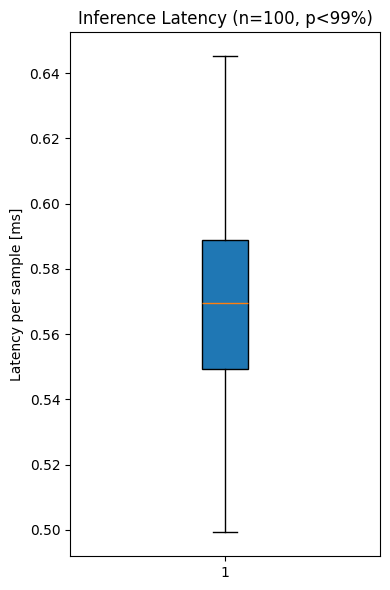

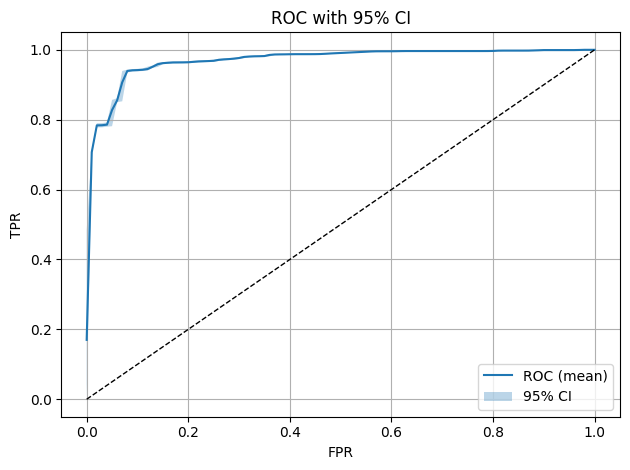

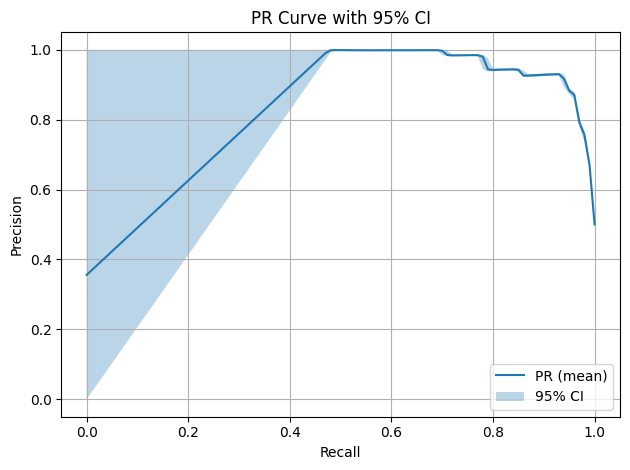

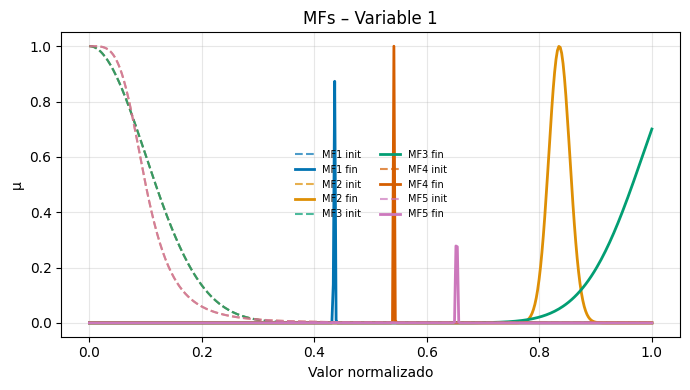

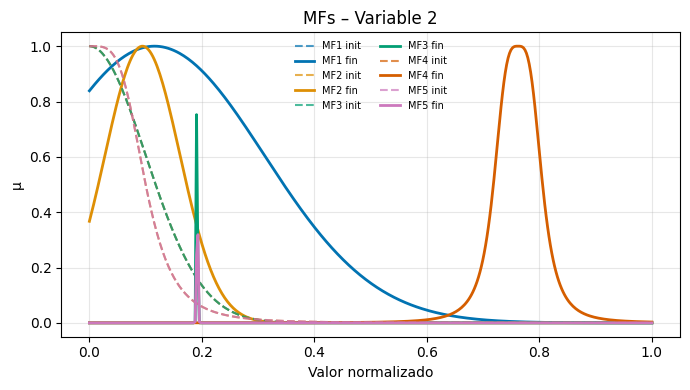

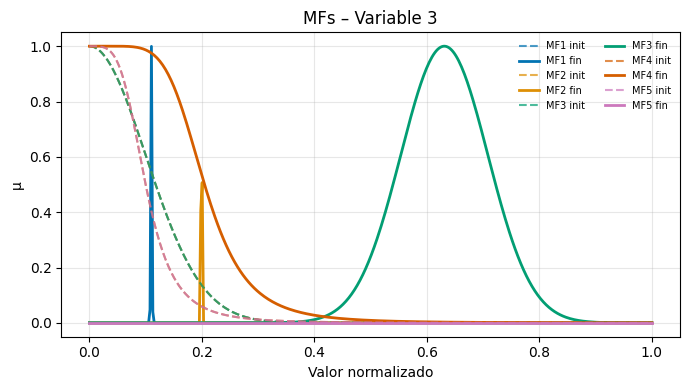

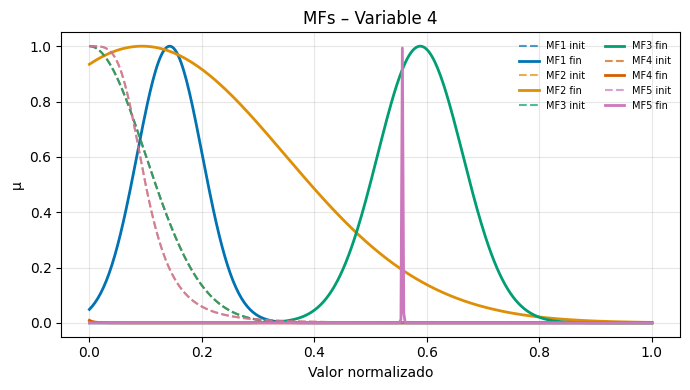

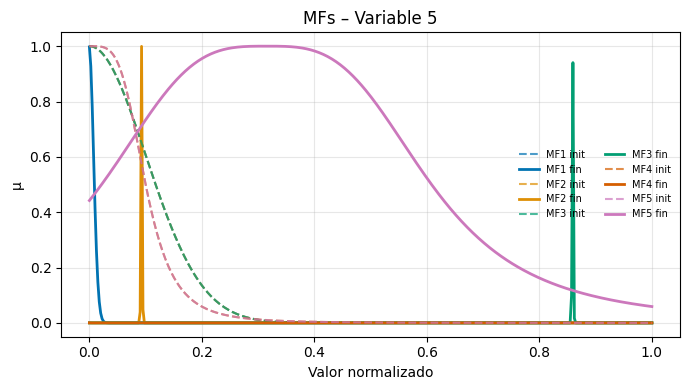

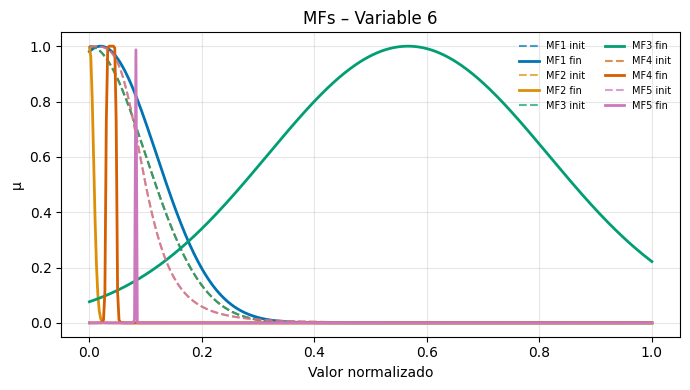

'### Fin del notebook'

In [16]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# %% [markdown]
"""
# Post‑analysis v3 – **Jupyter version**

Este _notebook_ reproduce todas las tablas y figuras **faltantes** del script
«ANFIS OPT v3».  Está estructurado en celdas para ejecutarse directamente en
Visual Studio Code (Python 3.10.16) con la funcionalidad _Jupyter Interactive_.

> **Requisitos previos**  
> * Carpeta del proyecto con los artefactos generados por el entrenamiento
>   original: `models/`, `outputs/`, datasets CSV, etc.  
> * Entorno con las mismas versiones de `torch`, `pandas`, `numpy`,
>   `scikit‑learn`, `matplotlib`, `seaborn` y `joblib`.

**Contenido del notebook**

| Sección | Salida principal |
|---------|-----------------|
| Configuración & utilidades | — |
| Carga de datos y modelo | — |
| Tabla de hiper‑parámetros finales | `table_hyperparams_final.csv` |
| Box‑plot de latencia (100 muestras) | `fig_latency_boxplot_100.png` |
| Métricas ± IC 95 % (bootstrap) | `table_metrics_ci.csv` |
| Curvas ROC / PR ± IC 95 % | `fig_roc_ci.png`, `fig_pr_ci.png` |
| Top‑5 errores clasificados | `table_top5_misclassified.csv` |
| Superposición de MFs | `fig_mf_overlay.png` |

Para ejecutar, vaya avanzando celda por celda (`Run Cell` ⇧⏎) o ejecute todo el
notebook (`Run All Cells`).
"""

# %%
# Configuración general ----------------------------------------------------
import os, random, time, warnings
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score,
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs('outputs', exist_ok=True)
print(f"Dispositivo: {DEVICE}")

# %% [markdown]
"""## Definición mínima del modelo ANFIS
Solo es necesaria para exponer las _membership functions_ (MFs) y poder cargar
el estado guardado. El método `forward` **no** se utiliza aquí."""

# %%
class GaussianMF(torch.nn.Module):
    def __init__(self, mu, sigma):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.tensor(mu))
        self.sigma = torch.nn.Parameter(torch.tensor(sigma))
    def forward(self, x):
        return torch.exp(-0.5 * ((x - self.mu) / torch.clamp(self.sigma, min=1e-3)) ** 2)

class GBellMF(torch.nn.Module):
    def __init__(self, a, b, c):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(a))
        self.b = torch.nn.Parameter(torch.tensor(b))
        self.c = torch.nn.Parameter(torch.tensor(c))
    def forward(self, x):
        a = torch.clamp(self.a, min=1e-3)
        b = torch.clamp(self.b, min=1e-3)
        return 1.0 / (1 + torch.abs((x - self.c) / a) ** (2 * b))

from sklearn.cluster import KMeans

def init_centers(x_np: np.ndarray, k: int) -> np.ndarray:
    return np.array([
        np.sort(KMeans(k, n_init=10, random_state=SEED).fit(col.reshape(-1, 1)).cluster_centers_.flatten())
        for col in x_np.T
    ])

class ANFISHybrid(torch.nn.Module):
    N_GAUSS = 3
    N_GBELL = 2
    def __init__(self, n_in: int):
        super().__init__()
        g_c = init_centers(np.zeros((10, n_in)), self.N_GAUSS)
        gb_c = init_centers(np.zeros((10, n_in)), self.N_GBELL)
        self.mfs = torch.nn.ModuleList([
            torch.nn.ModuleList([
                *[GaussianMF(c, 0.1) for c in g_c[i]],
                *[GBellMF(0.1, 2.0, c) for c in gb_c[i]],
            ]) for i in range(n_in)
        ])
        self.rule_cls_w = torch.nn.Parameter(torch.empty(0, 2))
    def forward(self, x):
        raise RuntimeError("Solo para inspección; no se usa en inferencia.")

# %% [markdown]
"""## Funciones auxiliares"""

# %%
@dataclass
class MetricsCI:
    mean: float
    lower: float
    upper: float

def ci_from_bootstrap(samples: np.ndarray, alpha: float = 0.05) -> MetricsCI:
    low, up = np.percentile(samples, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return MetricsCI(samples.mean(), low, up)

BOOTSTRAP_ITER = 1000
CI_LEVEL = 0.95
FPR_POINTS = np.linspace(0, 1, 101)
REC_POINTS = np.linspace(0, 1, 101)

# %% [markdown]
"""## Carga de datos y modelo"""

# %%
print("→ Cargando scaler y datasets …")
scaler: MinMaxScaler = joblib.load('models/minmax_scaler_v3.joblib')
X = pd.read_csv('13_X_fuzzy_filtrado_final.csv').values
y = pd.read_csv('06_y_labels.csv').iloc[:, 0].values.ravel()
X_scaled = scaler.transform(X)

from sklearn.model_selection import train_test_split
_, X_tmp, _, y_tmp = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=SEED)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED)
X_te_t = torch.tensor(X_te, dtype=torch.float32, device=DEVICE)

print("→ Cargando modelo TorchScript …")
model_ts = torch.jit.load('models/anfis_model_v3_torchscript.pt', map_location=DEVICE)
model_ts.eval()

print("→ Reconstruyendo modelo Python para inspección …")
model_inspect = ANFISHybrid(n_in=X.shape[1])
state = model_ts.state_dict()
state.pop('rule_cls_w', None)        # ← descarta el parámetro conflictivo
model_inspect.load_state_dict(state, strict=False)
model_inspect.eval()

# %% [markdown]
"""## Inferencia en test"""

# %%
with torch.no_grad():
    logits = model_ts(X_te_t)
    if isinstance(logits, tuple):
        logits = logits[0]
    prob_te = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

y_pred_te = (prob_te >= 0.5).astype(int)
print(f"AUC‑ROC test: {roc_auc_score(y_te, prob_te):.3f}")

# %% [markdown]
"""## Tabla de hiper‑parámetros finales"""

# %%
hyperparams = pd.read_csv('outputs/table2_hyperparams.csv')
hyperparams['Selected'] = 'Sí'  # marcado manual
hyperparams.to_csv('outputs/table_hyperparams_final.csv', index=False)
hyperparams

# %% [markdown]
"""## Box‑plot de latencia (100 muestras)"""
lat_samples = X_te_t[:100]
latencies = []
with torch.no_grad():
    for xb in lat_samples:
        t0 = time.perf_counter()
        _ = model_ts(xb.unsqueeze(0))
        latencies.append((time.perf_counter() - t0) * 1e3)   # ms

latencies = np.array(latencies)
latencies = latencies[latencies <= np.percentile(latencies, 99)]  # filtra p99

plt.figure(figsize=(4, 6))
plt.boxplot(latencies, vert=True, patch_artist=True, showfliers=False)
plt.ylabel('Latency per sample [ms]')
plt.title('Inference Latency (n=100, p<99%)')
plt.tight_layout()
plt.savefig('outputs/fig_latency_boxplot_100.png', dpi=300)
plt.show()

# %% [markdown]
"""## Métricas con IC 95 % (bootstrap)"""

# %%
metrics_boot = []
rng = np.random.default_rng(SEED)
for _ in range(BOOTSTRAP_ITER):
    idx = rng.choice(len(y_te), size=len(y_te), replace=True)
    y_b = y_te[idx]
    p_b = prob_te[idx]
    y_pred_b = (p_b >= 0.5).astype(int)
    metrics_boot.append([
        accuracy_score(y_b, y_pred_b),
        precision_score(y_b, y_pred_b, zero_division=0),
        recall_score(y_b, y_pred_b, zero_division=0),
        f1_score(y_b, y_pred_b, zero_division=0),
        roc_auc_score(y_b, p_b),
    ])
metrics_boot = np.stack(metrics_boot)
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC‑ROC']
rows = []
for i, name in enumerate(metric_names):
    ci = ci_from_bootstrap(metrics_boot[:, i], alpha=1-CI_LEVEL)
    rows.append({'Metric': name, 'Mean': ci.mean, 'CI_lower': ci.lower, 'CI_upper': ci.upper})
metrics_ci_df = pd.DataFrame(rows)
metrics_ci_df.to_csv('outputs/table_metrics_ci.csv', index=False)
metrics_ci_df

# %% [markdown]
"""## Curvas ROC y PR con bandas de confianza"""

# %%
roc_boot, pr_boot = [], []
for _ in range(BOOTSTRAP_ITER):
    idx = rng.choice(len(y_te), size=len(y_te), replace=True)
    y_b = y_te[idx]
    p_b = prob_te[idx]
    fpr, tpr, _ = roc_curve(y_b, p_b)
    roc_boot.append(np.interp(FPR_POINTS, fpr, tpr))
    prec, rec, _ = precision_recall_curve(y_b, p_b)
    pr_boot.append(np.interp(REC_POINTS, rec[::-1], prec[::-1]))
roc_boot = np.stack(roc_boot)
pr_boot = np.stack(pr_boot)
roc_mean, roc_low, roc_up = roc_boot.mean(0), np.percentile(roc_boot, 2.5, 0), np.percentile(roc_boot, 97.5, 0)
pr_mean, pr_low, pr_up = pr_boot.mean(0), np.percentile(pr_boot, 2.5, 0), np.percentile(pr_boot, 97.5, 0)

# ROC
plt.figure()
plt.plot(FPR_POINTS, roc_mean, label='ROC (mean)')
plt.fill_between(FPR_POINTS, roc_low, roc_up, alpha=0.3, label='95% CI')
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC with 95% CI'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig('outputs/fig_roc_ci.png', dpi=300); plt.show()
# PR
plt.figure()
plt.plot(REC_POINTS, pr_mean, label='PR (mean)')
plt.fill_between(REC_POINTS, pr_low, pr_up, alpha=0.3, label='95% CI')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve with 95% CI'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig('outputs/fig_pr_ci.png', dpi=300); plt.show()

# %% [markdown]
"""## Top‑5 registros mal clasificados"""

# %%
errors_idx = np.where(y_pred_te != y_te)[0]
conf_scores = np.abs(prob_te[errors_idx] - 0.5)
sel = errors_idx[np.argsort(conf_scores)[-5:][::-1]] if len(errors_idx) >= 5 else errors_idx
explain = []
for ix in sel:
    note = 'Alta confianza errónea' if conf_scores[np.where(errors_idx==ix)][0] > 0.25 else 'Cerca del umbral'
    explain.append({'index': int(ix), 'true': int(y_te[ix]), 'pred': int(y_pred_te[ix]), 'prob': float(prob_te[ix]), 'note': note})
err_df = pd.DataFrame(explain)
err_df.to_csv('outputs/table_top5_misclassified.csv', index=False)
err_df

# %% [markdown]
"""## Superposición de MFs iniciales vs. aprendidas"""

# %%
# %%  ⇠  Superposición de MFs iniciales vs. aprendidas (multivariables, escala de grises)

var_indices = [0, 1, 2, 3, 4, 5]          # ← añada aquí los índices de las variables que desee visualizar
palette = sns.color_palette("colorblind", n_colors=len(init_model.mfs[0]))  # colores bien contrastados

for v in var_indices:
    x_axis = np.linspace(0, 1, 400)
    fig, ax = plt.subplots(figsize=(7, 4))

    for j, (mf_init, mf_fin, col) in enumerate(zip(init_model.mfs[v],
                                                   model_inspect.mfs[v],
                                                   palette)):
        y_init = mf_init(torch.tensor(x_axis, dtype=torch.float32)).detach().numpy()
        y_fin  = mf_fin (torch.tensor(x_axis, dtype=torch.float32)).detach().numpy()

        ax.plot(x_axis, y_init, linestyle='--', color=col, alpha=0.7, label=f'MF{j+1} init')
        ax.plot(x_axis, y_fin , linestyle='-',  color=col, linewidth=2, label=f'MF{j+1} fin')

    ax.set_xlabel('Valor normalizado')
    ax.set_ylabel('µ')
    ax.set_title(f'MFs – Variable {v+1}')
    ax.grid(True, alpha=.3)
    ax.legend(ncol=2, fontsize=7, frameon=False)

    plt.tight_layout()
    plt.savefig(f'outputs/fig_mf_overlay_var{v}.png', dpi=300)
    plt.show()


# %% [markdown]
"""### Fin del notebook"""


In [1]:
# %%
# Configuración general ----------------------------------------------------
import os, random, time, warnings
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score,
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs('outputs', exist_ok=True)
print(f"Dispositivo: {DEVICE}")

# %% [markdown]
"""## Definición mínima del modelo ANFIS
Solo es necesaria para exponer las _membership functions_ (MFs) y poder cargar
el estado guardado. El método `forward` **no** se utiliza aquí."""

# %%
class GaussianMF(torch.nn.Module):
    def __init__(self, mu, sigma):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.tensor(mu))
        self.sigma = torch.nn.Parameter(torch.tensor(sigma))
    def forward(self, x):
        return torch.exp(-0.5 * ((x - self.mu) / torch.clamp(self.sigma, min=1e-3)) ** 2)

class GBellMF(torch.nn.Module):
    def __init__(self, a, b, c):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(a))
        self.b = torch.nn.Parameter(torch.tensor(b))
        self.c = torch.nn.Parameter(torch.tensor(c))
    def forward(self, x):
        a = torch.clamp(self.a, min=1e-3)
        b = torch.clamp(self.b, min=1e-3)
        return 1.0 / (1 + torch.abs((x - self.c) / a) ** (2 * b))

from sklearn.cluster import KMeans

def init_centers(x_np: np.ndarray, k: int) -> np.ndarray:
    return np.array([
        np.sort(KMeans(k, n_init=10, random_state=SEED).fit(col.reshape(-1, 1)).cluster_centers_.flatten())
        for col in x_np.T
    ])

class ANFISHybrid(torch.nn.Module):
    N_GAUSS = 3
    N_GBELL = 2
    def __init__(self, n_in: int):
        super().__init__()
        g_c = init_centers(np.zeros((10, n_in)), self.N_GAUSS)
        gb_c = init_centers(np.zeros((10, n_in)), self.N_GBELL)
        self.mfs = torch.nn.ModuleList([
            torch.nn.ModuleList([
                *[GaussianMF(c, 0.1) for c in g_c[i]],
                *[GBellMF(0.1, 2.0, c) for c in gb_c[i]],
            ]) for i in range(n_in)
        ])
        self.rule_cls_w = torch.nn.Parameter(torch.empty(0, 2))
    def forward(self, x):
        raise RuntimeError("Solo para inspección; no se usa en inferencia.")

# %% [markdown]
"""## Funciones auxiliares"""

# %%
@dataclass
class MetricsCI:
    mean: float
    lower: float
    upper: float

def ci_from_bootstrap(samples: np.ndarray, alpha: float = 0.05) -> MetricsCI:
    low, up = np.percentile(samples, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return MetricsCI(samples.mean(), low, up)

BOOTSTRAP_ITER = 1000
CI_LEVEL = 0.95
FPR_POINTS = np.linspace(0, 1, 101)
REC_POINTS = np.linspace(0, 1, 101)

# %% [markdown]
"""## Carga de datos y modelo"""

# %%
print("→ Cargando scaler y datasets …")
scaler: MinMaxScaler = joblib.load('models/minmax_scaler_v3.joblib')
X = pd.read_csv('13_X_fuzzy_filtrado_final.csv').values
y = pd.read_csv('06_y_labels.csv').iloc[:, 0].values.ravel()
X_scaled = scaler.transform(X)

from sklearn.model_selection import train_test_split
_, X_tmp, _, y_tmp = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=SEED)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED)
X_te_t = torch.tensor(X_te, dtype=torch.float32, device=DEVICE)

print("→ Cargando modelo TorchScript …")
model_ts = torch.jit.load('models/anfis_model_v3_torchscript.pt', map_location=DEVICE)
model_ts.eval()

print("→ Reconstruyendo modelo Python para inspección …")
model_inspect = ANFISHybrid(n_in=X.shape[1])
state = model_ts.state_dict()
state.pop('rule_cls_w', None)        # ← descarta el parámetro conflictivo
model_inspect.load_state_dict(state, strict=False)
model_inspect.eval()

# %% [markdown]
"""## Inferencia en test"""

# %%
with torch.no_grad():
    logits = model_ts(X_te_t)
    if isinstance(logits, tuple):
        logits = logits[0]
    prob_te = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

y_pred_te = (prob_te >= 0.5).astype(int)
print(f"AUC‑ROC test: {roc_auc_score(y_te, prob_te):.3f}")

# %% [markdown]
"""## Tabla de hiper‑parámetros finales"""

# %%
hyperparams = pd.read_csv('outputs/table2_hyperparams.csv')
hyperparams['Selected'] = 'Sí'  # marcado manual
hyperparams.to_csv('outputs/table_hyperparams_final.csv', index=False)
hyperparams

# %% [markdown]
"""## Top-5 registros con falsos negativos"""

# Selecciona índices donde la etiqueta real sea 1 (ddos) y la predicción 0 (normal)
fn_idx = np.where((y_te == 1) & (y_pred_te == 0))[0]

# Distancia a 0.5 como medida de confianza (|prob - 0.5|)
conf_scores = np.abs(prob_te[fn_idx] - 0.5)

# Escoge los 5 de mayor confianza errónea (o todos si hay <5)
sel = fn_idx[np.argsort(conf_scores)[-5:][::-1]] if len(fn_idx) >= 5 else fn_idx

# Ensambla la tabla
records = []
for ix in sel:
    note = "Alta confianza errónea" if conf_scores[np.where(fn_idx == ix)][0] > 0.25 else "Cerca del umbral"
    records.append({
        "index": int(ix),
        "true":  int(y_te[ix]),      # siempre 1 en este filtro
        "pred":  int(y_pred_te[ix]), # siempre 0 en este filtro
        "prob":  float(prob_te[ix]), # probabilidad asignada a la clase ‘ddos’
        "note":  note
    })

fn_df = pd.DataFrame(records)

# Guarda y muestra
fn_df.to_csv("outputs/table_top5_false_negatives.csv", index=False)
fn_df


Dispositivo: cpu
→ Cargando scaler y datasets …
→ Cargando modelo TorchScript …
→ Reconstruyendo modelo Python para inspección …
AUC‑ROC test: 0.972


,index,true,pred,prob,note
0,15550,1,0,0.140940,Alta confianza errónea
1,5779,1,0,0.169781,Alta confianza errónea
2,6424,1,0,0.169789,Alta confianza errónea
3,7127,1,0,0.169789,Alta confianza errónea
4,29380,1,0,0.169822,Alta confianza errónea
